# time series forecasting tutorial

Forecasting is used in a wide variety of contexts to anticipate future outcomes over a range of time horizons — hourly electricity consumption, daily precipitation totals, quarterly product demand, etc. — and plan accordingly. The predictability of an event or value depends on how well we understand its causes, how much information is available in advance, and whether the forecast affects the outcome itself. Good forecasts identify and extrapolate meaningful patterns and relationships from past information while ignoring random/atypical variation.

In this tutorial, we'll focus on time series forecasting: the use of numerical, sequential data collected at regular intervals over time in order to predict future observations. Simple models rely only on historical values of the target variable, while more complex "mixed" models also incorporate relevant predictor variables; as always, selecting an appropriate model depends on context.

Any given forecasting task consists of the following steps:

1. **problem definition**: Defining how a forecast will be used, by whom, and for what purpose.
2. **information gatherinng**: Acquiring sufficient data and domain expertise to produce a good forecast.
3. **exploratory data analysis**: Developing an understanding of the data's broad contours, eccentricities, and key attributes through graphs and statistics.
4. **model selection and fitting** Choosing a model based on the data and use case, and fitting it to the available data.
5. **model evaluation**: Assessing the quality of the fit model's forecasts on new or held-out data.

Then, of course, putting the model and its forecasts to use!

## technical setup

But first...

```
$ git clone git@github.com:bdewilde/time-series-forecasting-study.git
$ cd time-series-forecasting-study
$ pip install -e .
$ pip install -e .[dev]
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import statsmodels.api as sm

from data_dives import time_series_forecasting as tsf

In [2]:
# set some default plot params
plt.rcParams.update(
    {
        "figure.figsize": (16, 6),
        "axes.labelsize": "x-large",
        "legend.fontsize": "x-large",
        "legend.frameon": False,
        "lines.linewidth": 2,
    }
)

## 1. problem definition

Climate change is a large and growing existential threat to life on our planet. According to scientific consensus, human-caused emission of greenhouse gasses (GHGs) into the atmosphere is the dominant driver of this phenomenon. Can we predict future atmospheric GHG concentrations over the course of the next ten years, assuming humanity doesn't dramatically change course, in order to show where "business as usual" will get us?

## 2. information gathering

Different GHGs affect the atmosphere and climate differently, depending on their concentration, longevity, and heat-trapping potential. The large majority of anthropogenic GHG emissions are in the form of carbon dioxide (CO2), produced by burning fossil fuels (coal, gas, oil) and some chemical reactions (e.g. cement manufacture) [[source](https://www.epa.gov/ghgemissions/overview-greenhouse-gases)]. Plus, it's the most well-known and -studied of the bunch. Since humanity has been changing the concentration relatively slowly over the course of many years, we want a time series dataset of atmospheric CO2 concentrations spanning at least a couple of decades.

The Mauna Loa Observatory has been taking high-quality and well-validated measurements of atmospheric CO2 concentrations since the 1950s [[source](https://www.esrl.noaa.gov/gmd/ccgg/about/co2_measurements.html)], and that data is readily available from the [Scipps Institution of Oceanography](https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html) or [National Oceanic and Atmospheric Administration](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html). Turns out we've been using the term "concentration" loosely: values are actually "mole fractions" in units of parts-per-million (ppm), defined as the number of CO2 molecules in a given number of air molecules after removal of water vapor.

Lastly, it's worth noting that our forecast will not be "good" because it violates a couple key assumptions: that humanity will do nothing to change its GHG emissions over the next decade, and that the forecast doesn't affect the outcome. Although emissions aren't decreasing nearly fast enough, recent technological and political progress signify that big changes are already underway. Also, governments / scientists have been making forecasts like this for years in order to influence our emissions trajectory, and I'm doing the same thing (albeit with a much smaller influence). Still, it's a nice subject for a tutorial.

### data acquisition

First, let's download daily in-situ CO2 concentration measurements from 1958 – Present, via Scipps. We leave the "raw" dataset as-is, except for skipping the first ~30 rows, where the researchers have included dataset metadata that breaks the CSV format.

In [3]:
data_orig = tsf.datasets.load_mlo_co2()
data_orig

,% Yr,Mn,Dy,CO2,NB,scale
0,1958,1,1,NaN,0,8.1
1,1958,1,2,NaN,0,8.1
2,1958,1,3,NaN,0,8.1
3,1958,1,4,NaN,0,8.1
4,1958,1,5,NaN,0,8.1
...,...,...,...,...,...,...
23037,2021,1,27,NaN,0,8.1
23038,2021,1,28,NaN,0,8.1
23039,2021,1,29,NaN,0,8.1
23040,2021,1,30,NaN,0,8.1


### data wrangling

We have to tidy and transform — "wrangle" — this raw dataset to get it into analysis-ready form. In general, that entails:

- cleaning up column names and data types
- creating / setting a proper datetime index
- dropping any unnecessary columns
- resampling the frequency of observations, if desired
- handling missing values by filling (forward or via interpolation) and/or dropping rows

Under the hood, this is all done in `pandas`. Let's resample to monthly frequency data, since our forecast's time horizon is _years_ and this should smooth out some of the random fluctuation in the daily measurements. (And, as we'll see, the data has a seasonal component that can be split neatly into months.) Let's also interpolate any missing values rather than forward fill, since we can reasonably expect the values to change smoothly from month to month.

In some cases, we might also like to transform the values in order to remove known sources of variation and thereby simplify the data before modeling. For example, we might normalize values that depend on population by total population to get per-capita equivalents, or adjust financial data by inflation to make fairer comparisons of absolute amounts. In this case, however, we should be fine as-is: Our monthly values are averaged over constituent days, so we don't have to adjust for the oddities of our calendar such as months having different numbers of days.

In [4]:
# if curious, take a peak at the source code
# tsf.datasets.munge_mlo_co2??

In [5]:
data = tsf.datasets.munge_mlo_co2(data_orig, freq="MS", fill="interpolate")
data

,CO2
dt,
1958-03-01,316.425
1958-04-01,317.438462
1958-05-01,317.471111
1958-06-01,316.598142
1958-07-01,315.753333
...,...
2020-09-01,411.315385
2020-10-01,411.292143
2020-11-01,413.000345


## 3. exploratory data analysis

Our dataset is simple: it consists of just one dependent variable (`"CO2"`) measured at a sequence of datetimes, without any gaps or fundamental changes in the underlying process producing these values. Fortunately, this makes it straightforward to work with!

The goal of exploratory data analysis is to get acquainted with the important and relevant characteristics of a dataset through graphs and statistics — and, in this particular task, to facilitate better forecasting in step 4.

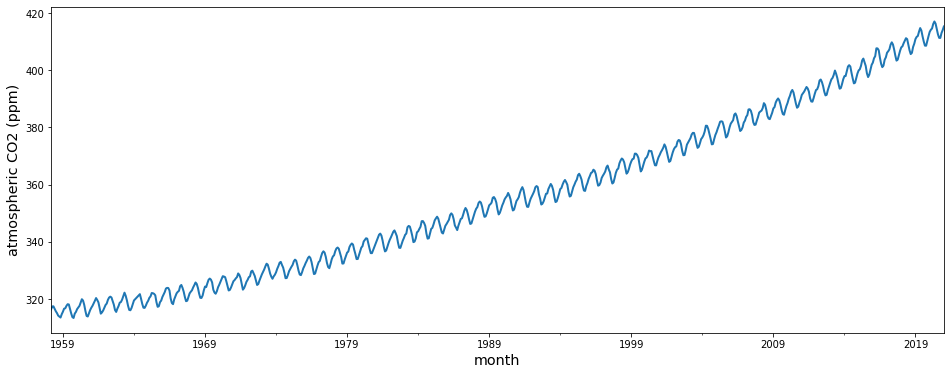

In [6]:
_ = data["CO2"].plot.line(xlabel="month", ylabel="atmospheric CO2 (ppm)")

In this time plot, we can see a clear and increasing trend — which scientists have attributed to human activity. We also see regular variation at yearly intervals comprised of 12 monthly observations apiece, which arise from natural processes like the seasonal growth and decay of plants (dominated by the northern hemisphere, which has a larger land biosphere than the southern) [[source](https://svs.gsfc.nasa.gov/4565)]. Changes are smooth, without any apparent discontinuities or outlier values. Seems like a simple time series, which should make modeling it more straightforward.

One thing does catch my eye: It looks like the overall trend may be non-linear — that is, increasing in slope over time rather than just a straight line. Let's plot annual percent changes over time to check:

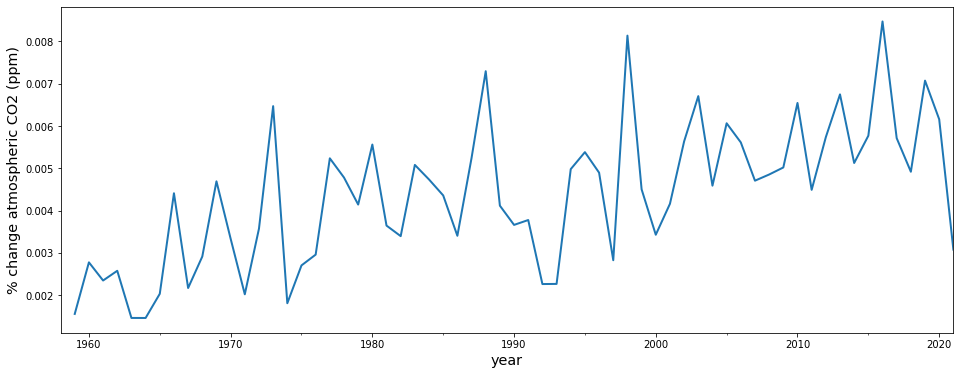

In [7]:
_ = data["CO2"].resample("Y").mean().pct_change().plot.line(
    xlabel="year", ylabel="% change atmospheric CO2 (ppm)",
)

Yup, looks like CO2 concentrations have increased at an increasing rate, though _maybe_ they're stating to level off. Yikes! Emissions aren't just going in the wrong direction, they're going their faster than before... This is something we might have to adjust for when modeling later on.

We can also take a closer look at the repeating annual pattern using a "seasonal plot", which takes each season's observations and plots them one on top of the other rather than one after the other as in the time plot above. I've taken some artistic liberty and colored each year's observations to suggest the corresponding change in global temperature.

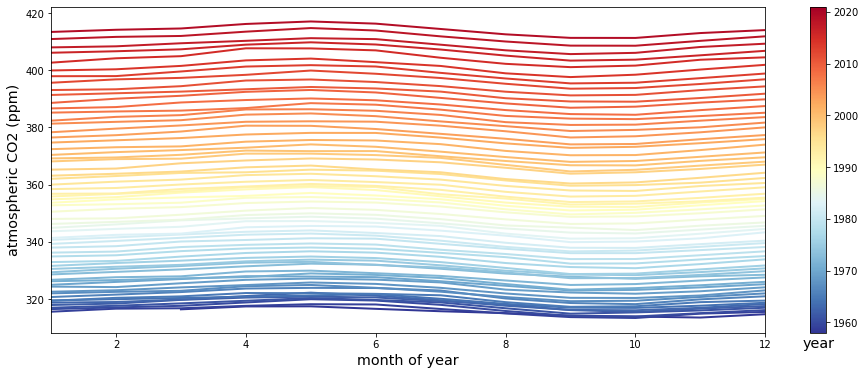

In [8]:
data_grped = data.groupby(by=data.index.year)

fig, ax = plt.subplots()
cmap = plt.cm.get_cmap(name="RdYlBu_r")
cmap_norm = mpl.colors.Normalize(vmin=data.index.year.min(), vmax=data.index.year.max())
for i, (year, grp) in enumerate(data_grped):
    ax.plot(grp.index.month, grp.values, color=cmap(i / len(data_grped)), label=year)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=cmap_norm, cmap=cmap), ax=ax)
cbar.ax.set_xlabel("year")
_ = ax.set_ylabel("atmospheric CO2 (ppm)")
_ = ax.set_xlabel("month of year")
_ = ax.set_xlim(left=1, right=12)

We can see that annual atmospheric CO2 concentrations are highest around May and lowest around October, which clearly reflects the role of growing plants in removing CO2 and decaying plants in emitting it.

We should also inspect the distribution of values for our dependent variable.

In [9]:
data.describe()

,CO2
count,755.000000
mean,355.752502
std,29.132317
min,313.402222
25%,329.183483
50%,352.782759
75%,379.302373
max,417.049231


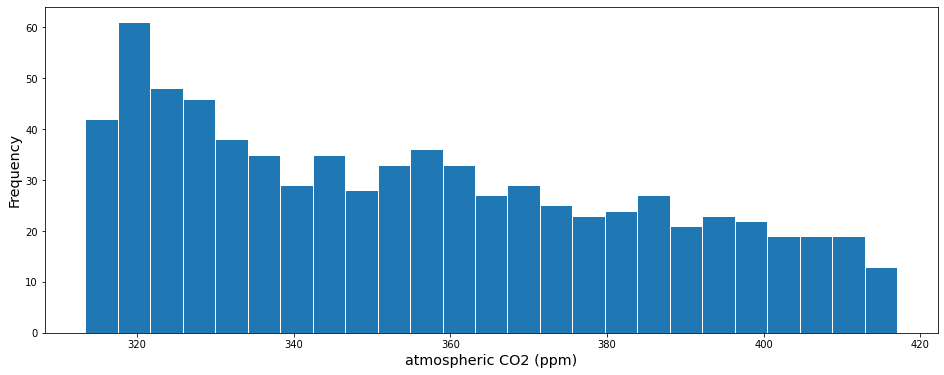

In [10]:
ax = data["CO2"].plot.hist(bins=25, ec="white")
_ = ax.set_xlabel("atmospheric CO2 (ppm)")

As we might've guessed, the values are not normally distributed.

If our dataset had included multiple predictor variables, we would also want to inspect and quantify the relationships between them; fortunately, `pandas` makes this easy! We could use a scatterplot matrix to visualize each pairwise relationship: `pd.plotting.scatter_matrix(data, diagonal="hist")` [[link](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#scatter-matrix-plot)]. Correlation coefficients measure the linear relationship between variables, so can be potentially misleading; but again, `pandas` comes through: `data.corr(method="spearman")`.

In [11]:
data.corr(method="spearman")  # not useful here :)

,CO2
CO2,1.0


Similarly, "autocorrelation" measures the linear relationship between _lagged_ values in a time series — that is, $y_{t}$ vs. $y_{t - k}$. Autocorrelation coefficients are typically computed at multiple lags, from $k = 1$ (comparing values to the immediately preceding values) on up. However, correlations for lag $k > 1$ may be affected by / artifacts of correlations at smaller lags. To clarify the situation, we also look at the _partial_ autocorrelations, which measure the relationship between $y_{t}$ and $y_{t − k}$ after removing the effect of lags at $1, 2, ... , k − 1$.

It's common to plot these values all together in a "correlogram" to show how they change with $k$. To assess statistical significance, this often includes a shaded region indicating the confidence intervals for the given level; for example, setting `alpha=0.05` in the call below plots the 95% confidence intervals.

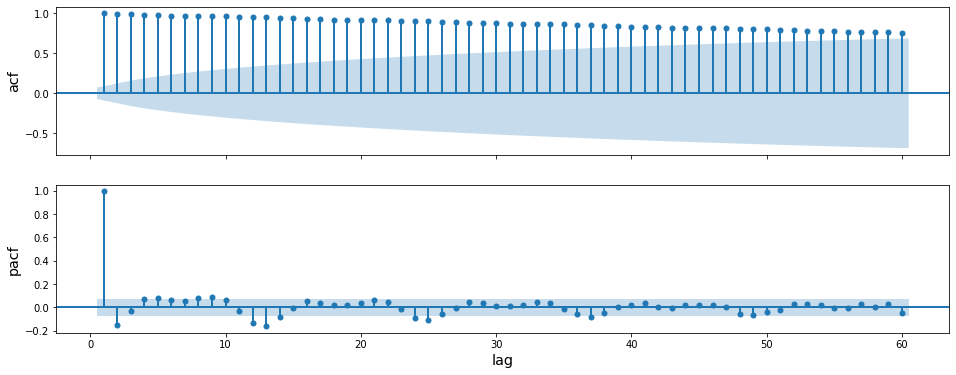

In [12]:
_ = tsf.viz.plot_autocorrelations(data["CO2"], lags=12 * 5, alpha=0.05)

From this, we can see that

- autocorrelations are large and positive at small lags then slowly decrease, which is indicative of a trend in the data
- partial autocorrelations are larger (in magnitude) at lag=1 and multiples of ~12, which corresponds to the seasonal component's frequency

We'll come back to autocorrelation in our discussion of modeling.

### decomposition

So far, I've tossed around terms like "trend" and "seasonality" loosely, but these actually have technical definitions and applications that merit discussion. Time series data can exhibit different types of patterns that may have different underlying causes; in fact, a time series may be split into the following components:

- **trend:** Long-term change of the dependent variable over time (e.g. the stock market increasing in good economic times and decreasing in bad... at least, back when the two were closely linked). It may encompass a "cyclic" component of slow ups/downs without a regular frequency (e.g. the "business cycle"), which is not to be confused with the seasonal component.
- **seasonal:** Repeating ups/downs with a regular frequency, owing to some property of the system (e.g. daily patterns in surface air temperature, weekly patterns in web site visitor traffic, annual patterns in energy consumption).
- **residual:** Everything left over, including random noise.

Certain use cases / forecasting models benefit from "de-trended" or "seasonally-adjusted" time series, but it's also just a useful way to better understand the data!

#### moving averages

A simple method for estimating trend is through the calculation of averages over a sliding window containing multiple observations. The window's size is typically a positive odd number (odd so that the window is _symmetric_ about the center point), but it's possible to make an even-order moving average symmetric by taking a moving average twice. In our case, based on the time and autocorrelation plots above, we know that our data exhibits annual seasonality (i.e. a period of 12 monthly observations), so let's use a 2 x 12-MA.

Moving averages may be weighted by some window function, e.g. exponential or gaussian decay about the window's center point, to produce smoother estimates, but for simplicity let's keep it unweighted.

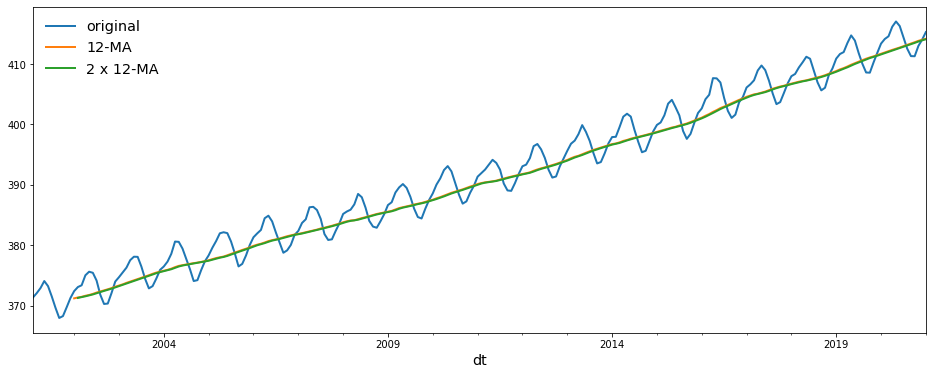

In [13]:
_ = tsf.viz.plot_time_series(
    [
        data["CO2"].tail(12 * 20),
        data["CO2"].tail(12 * 20).rolling(window=12).mean(),
        data["CO2"].tail(12 * 20).rolling(window=12).mean().rolling(window=2).mean(),
    ],
    ["original", "12-MA", "2 x 12-MA"],
    subplots=False,
)

#### classical decomposition

Another common but simplistic method combines time series components in one of two ways: additively (`y(t) = trend + seasonal + residual`) or multiplicatively (`y(t) = trend * seasonal * residual`), where `y(t)` is the value of the dependent variable at time `t`. If the components don't vary with the level of the data, use an additive decomposition; otherwise, go with multiplicative. Given that our CO2 concentration time series is _increasingly_ increasing year over year, we should probably decompose it multiplicatively.

In short, this method estimates the trend component by computing a moving average, as described above; the seasonal component by averaging de-trended values over all periods; and the residual component by taking the difference between original values and de-trended and -seasonalized values. It has some notable limitations — for example, it assumes that seasonal efects are the same over the entire time series, which may not necessarily be true — but it's a decent starting point.

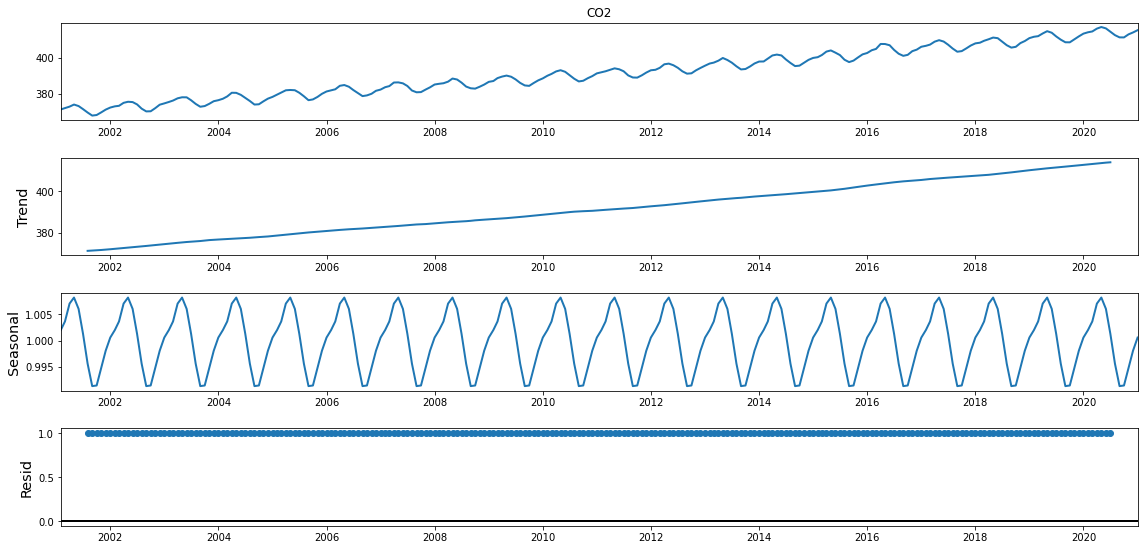

In [14]:
result = sm.tsa.seasonal_decompose(data["CO2"].tail(12 * 20), period=12, model="multiplicative")
fig = result.plot()
fig.set_size_inches(16, 8)

#### Seasonal and Trend decomposition using Loess (STL)

This method relies on LOESS (LOcally Estimated Scatterplot Smoothing) to extract smooth components. It's flexible and configurable, allows for changes in seasonality over time, and can be robust to outliers. However, it only handles additive decompositions (unless you mathematically transform your time series data on the way in and de-transform the component values on the way out — but this is a complication best set aside, for now).

The most important parameters to set are the length of the seasonal smoother (must be odd) and the length of the trend smoother (~1.5x the seasonal smoother, must also be odd), though there are several other knobs to fiddle.

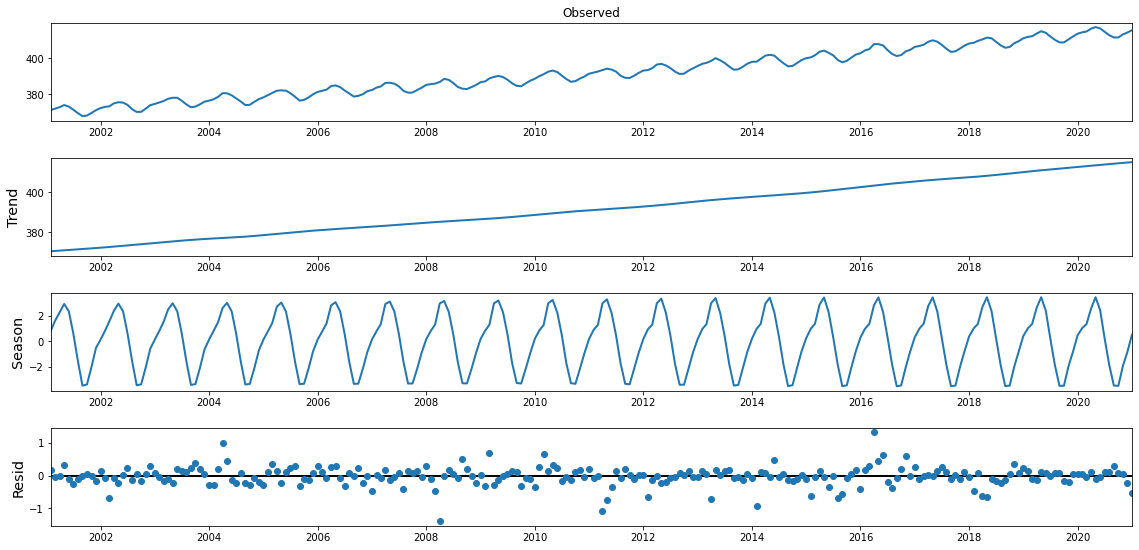

In [15]:
decomp = sm.tsa.STL(data[["CO2"]].tail(12 * 20), seasonal=13, trend=21, robust=True).fit()
fig = decomp.plot()
fig.set_size_inches(16, 8)

Note how the seasonal component changes slightly over the years.

If you find yourself eyeballing a decomposition plot and can't decide if there's a meaningful trend/seasonal component, it might help to compute a quantitative measure of the "strength" of those components. For data with a strong trend, we assume that the variation in seasonally-adjusted data should be much larger then variation in the residual component alone; an analogous assumption can be made for seasonal strength:

In [16]:
tsf.features.trend_strength(decomp)

0.999503569861223

In [17]:
tsf.features.seasonal_strength(decomp)

0.983109209995484

(Values close to 0 indicate a weak component, while those close to 1 indicate strong components.)

### stationarity

One final thing to check for is the "stationarity" of a time series: that is, do its statistical properties like mean and variance change over time or stay the same? Many time series are non-stationary because they have a trend / seasonal component or some other time-dependent characteristic, but some forecasting models only work on stationary data. There are mathematical transformations to _stationarize_ a time series, but first we need to know if it's necessary. This may be as easy as eye-balling a couple plots:

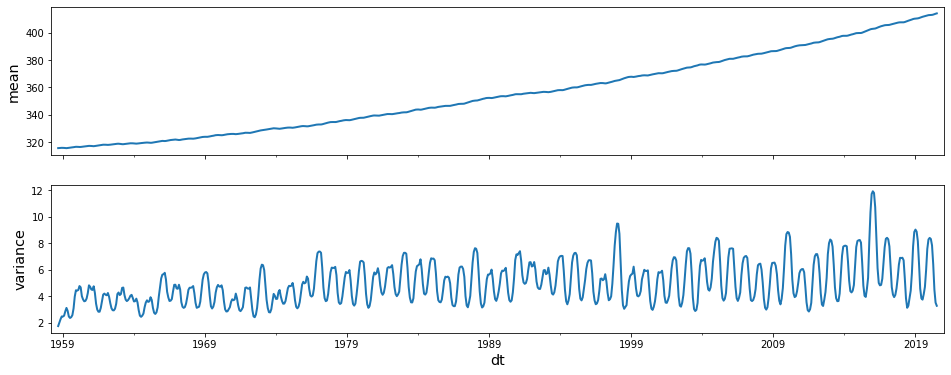

In [18]:
_ = tsf.viz.plot_time_series(
    [
        data["CO2"].rolling(window=13, center=True).mean(),
        data["CO2"].rolling(window=13, center=True).var(),
    ],
    labels=["mean", "variance"],
    subplots=True,
)

Clearly, our data's mean and variance change over time — there are predictable, long-term patterns — so we have a non-stationary time series. Another plot to check is the autocorrelation plot (discussed previously), which will have values that quickly go to ~0 for stationary data. Sometimes, though, eye-balling it isn't enough. In these cases, we can quantitatively assess stationarity using statistical tests; the most common tests are the Augmented Dickey Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests.

ADF performs a hypothesis test, where the null hypothesis is that the time series has a "unit root" — basically, how strongly a time series is defined by a trend. Failure to reject the null hypothesis provides evidence that the series is non-stationary.

In [19]:
tsf.stats.adfuller_test(data["CO2"])

stationarity             False
test statistic        4.853465
p-value                    1.0
num lags                    14
num obs                    740
critical value 1%    -3.439218
critical value 5%    -2.865454
critical value 10%   -2.568854
dtype: object

Since our significance test's p-value is >> 0.05, we've definitely failed to reject the null hypothesis; therefore (and as expected), the data is non-stationary.

Similarly, the KPSS test performs a hypothesis test where the null hypothesis is that the time series is level or trend stationary (note that this is reversed from ADF).

In [20]:
tsf.stats.kpss_test(data["CO2"])

/Users/burtondewilde/.pyenv/versions/3.9.1/envs/data-dives/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


stationarity              False
test statistic         4.229635
p-value                    0.01
num lags                     17
critical value 10%        0.347
critical value 5%         0.463
critical value 2.5%       0.574
critical value 1%         0.739
dtype: object

This time, we reject the null hypothesis with a p-value < 0.05, and can again conclude that the series is non-stationary.

In general, it's best to apply both tests, since their combined results give us great confidence in the conclusion, and potential insight into how we should stationarize the data, if required by our forecasting model. For example, if KPSS indicates non-stationarity but ADF indicates stationarity, the data should be stationarized through "differencing" — something we'll return to later in the context of ARIMA models.

## 4. model selection and fitting

So far, we've clearly defined our problem and developed intuitions about our dataset; based on this, we now have to select a suitable forecasting model. Fortunately (or not...), we have lots of options to choose from, with varying pros/cons. Some models are robust to outliers, handle complex seasonality, output prediction intervals, are quick to fit or easy to interpret, etc. In practice, we often explore a couple reasonable models, and ultimately select the one that performs best upon evaluation.

As mentioned early on, modeling univariate vs. multivariate time series datasets is quite different; given our dataset, we'll be choosing from models that forecast future values based on observed patterns in past values. In all cases, though, it's good to have a simple baseline against which to compare.

### naïve methods

In the case of non-seasonal data, a naïve method forecasts all future values as equal to the last observed value; for seasonal data, we instead forecast future values as equal to the last observed value corresponding to the same point in the season. Another method is the "drift" method, in which a straight line is drawn between the first and last observations then projected forward.

Yes, this is _really_ naïve! In most cases these are just benchmarks, but for certain types of time series data these methods can produce surprisingly decent forecasts...

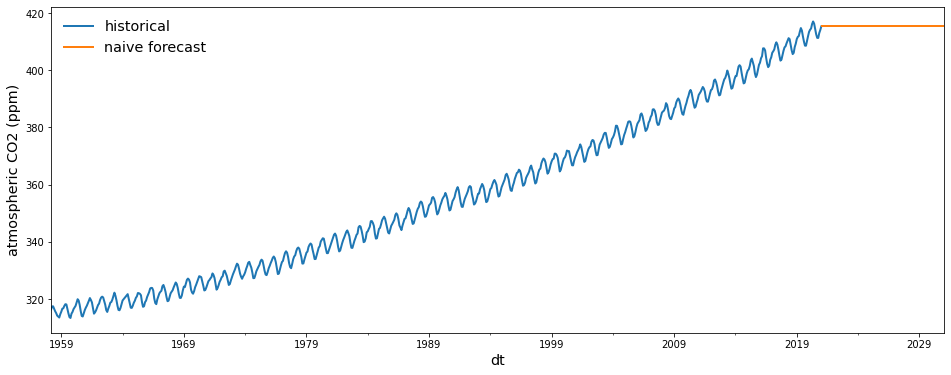

In [21]:
forecast = tsf.naive.naive_forecast(data["CO2"], steps=120)

_ = tsf.viz.plot_time_series(
    [data["CO2"], forecast],
    ["historical", "naive forecast"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)

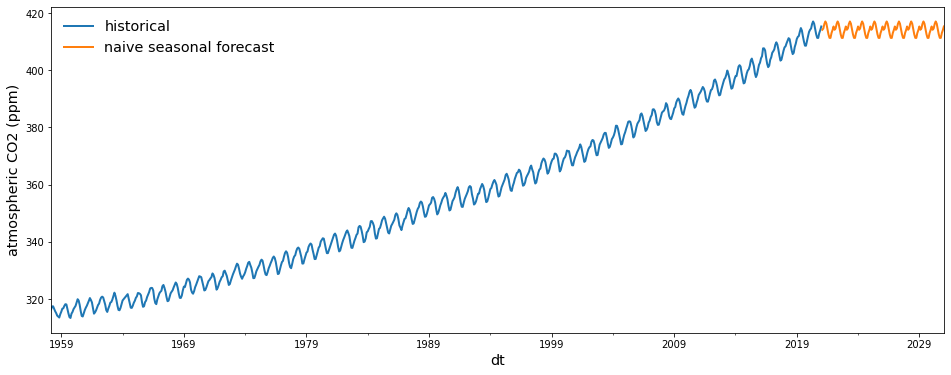

In [22]:
forecast = tsf.naive.naive_seasonal_forecast(data["CO2"], period=12, steps=120)

_ = tsf.viz.plot_time_series(
    [data["CO2"], forecast],
    ["historical", "naive seasonal forecast"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)

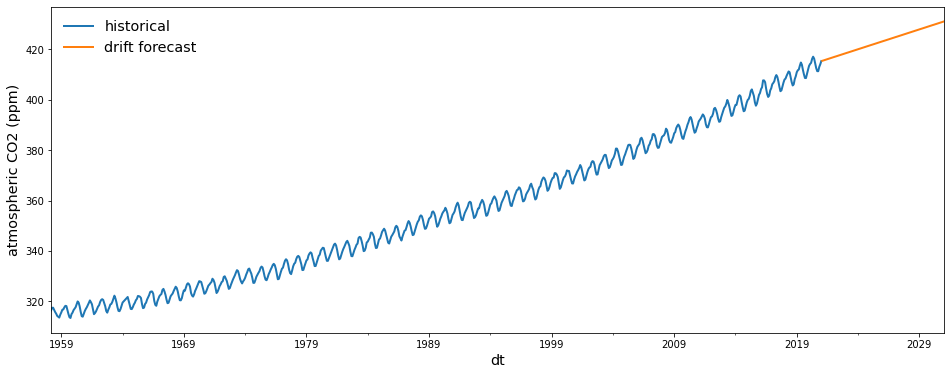

In [23]:
forecast = tsf.naive.drift_forecast(data["CO2"], steps=120)

_ = tsf.viz.plot_time_series(
    [data["CO2"], forecast],
    ["historical", "drift forecast"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)

### exponential smoothing models

A family of forecasting models are based on "exponential smoothing" — basically, computing weighted averages of past observations, where weights decay exponentially as the observations get farther back in time. It's a decent, general-purpose method.

#### simple exponential smoothing

This is the simplest version of this approach, and it's suitable for time series data without strong trend or seasonal components. (So, _not_ our dataset — at least, not without a suitable transformation.) Mathematically, this model can be expressed in component form, like so:

- forecast equation: $\hat{y}_{t + h | t} = \ell_{t}$
- smoothing equation: $\ell_{t} = \alpha y_{t} + (1 - \alpha) \ell_{t - 1}$

This model has two key parameters:

- smoothing level $\alpha$: the rate at which weights decay, where $0 \leq \alpha \leq 1$
- initial level $\ell_{0}$: the smoothed value of the series at time $t = 0$, from which subsequent fitted values (one-step forecasts of training data) are generated

The parameters may be initialized manually or inferred from the data; for convenience and reliability, let's have `statsmodels` find optimized values for us.

It's important to note that simple exponential smoothing model produces "flat" forecasts with a value equal to the last level value $\ell_{T}$ fit from the training data, which is why it doesn't work for data with trend or seasonal components.

In [24]:
result = (
    sm.tsa.SimpleExpSmoothing(data["CO2"].astype(float), initialization_method="estimated")
    .fit(smoothing_level=None, initial_level=None, optimized=True)
)
result.summary()

Dep. Variable:,CO2,No. Observations:,755
Model:,SimpleExpSmoothing,SSE,1158.887
Optimized:,True,AIC,327.516
Trend:,None,BIC,336.769
Seasonal:,None,AICC,327.569
Seasonal Periods:,None,Date:,"Fri, 05 Feb 2021"
Box-Cox:,False,Time:,12:39:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,316.42500,l.0,True


In [25]:
forecast = result.forecast(steps=120)

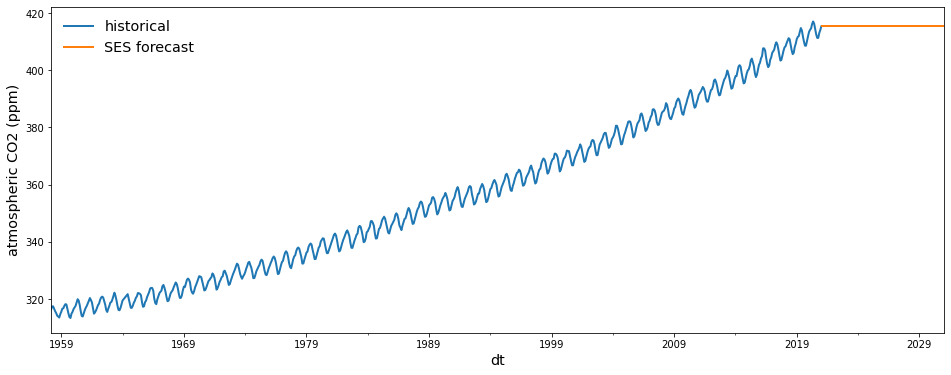

In [26]:
_ = tsf.viz.plot_time_series(
    [data["CO2"], forecast],
    ["historical", "SES forecast"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)

Looks similar to our naïve baseline model — that is to say, _not great_ — but fortunately there are extensions of this model that account for trend and seasonality.

#### Holt-Winters seasonal exponential smoothing

This method builds on simple exponential smoothing by adding smoothing equations for the trend and seasonal components, with corresponding smoothing parameters and seasonal period $m$. As we've seen before, this comes in both additive and multiplicative varieties, but we'll just describe the former here. In mathematical form:

- forecast equation: $\hat{y}_{t + h | t} = \ell_{t} + hb_{t} + s_{t + h - m(k + 1)}$
- smoothing equations (for level, trend, and seasonal components, respectively):

$$
\ell_{t} = \alpha (y_{t} - s_{t -m}) + (1 - \alpha)(\ell_{t - 1} + b_{t - 1}) \\
b_{t} = \beta^{*}(\ell_{t} - \ell_{t - 1}) + (1 - \beta^{*})b_{t - 1} \\
s_{t} = \gamma (y_{t} - \ell_{t - 1} - b_{t - 1}) + (1 - \gamma) s_{t - m}
$$

Or, in human-friendlier terms... The level equation represents a weighted average of the seasonally-adjusted observation at time $t$ and the non-seasonal one-step forecast; the trend equation represents a weighted average of the current (time $t$) and previous (time $t - 1$) estimated trends; and the seasonal equation represents a weighted average of the current seasonal index (time $t$) and that of the same point in the previous season (time $t - m$).

In [27]:
result = (
    sm.tsa.ExponentialSmoothing(
        data["CO2"].astype(float),
        trend="additive",
        seasonal="additive",
        seasonal_periods=12,
        initialization_method="estimated",
    )
    .fit(
        smoothing_level=None,
        smoothing_trend=None,
        smoothing_seasonal=None,
        optimized=True,
    )
)
result.summary()

Dep. Variable:,CO2,No. Observations:,755
Model:,ExponentialSmoothing,SSE,91.617
Optimized:,True,AIC,-1560.368
Trend:,Additive,BIC,-1486.341
Seasonal:,Additive,AICC,-1559.439
Seasonal Periods:,12,Date:,"Fri, 05 Feb 2021"
Box-Cox:,False,Time:,12:39:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5119369,alpha,True
smoothing_trend,0.0130382,beta,True


In [28]:
forecast = result.forecast(steps=120)
# simulations = result.simulate(120, repetitions=100, error="add")
# simulations.quantile(q=[0.1, 0.9], axis="columns").T

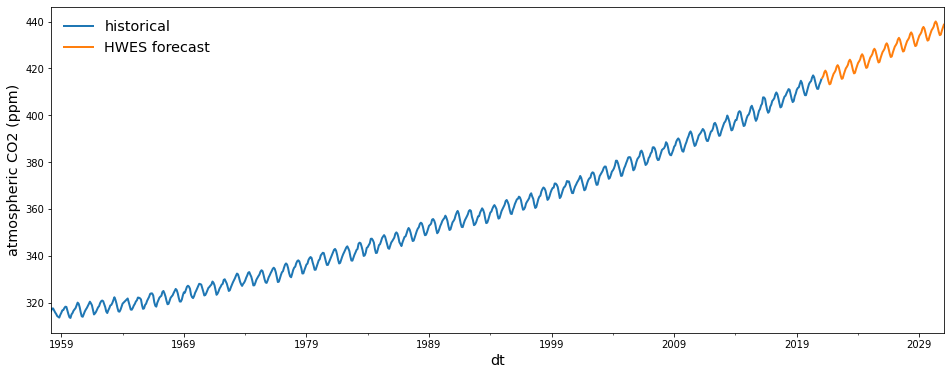

In [29]:
_ = tsf.viz.plot_time_series(
    [data["CO2"], forecast],
    ["historical", "HWES forecast"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)

Not bad! Later on we'll quantify what is meant by "bad" (or, ideally, "good" forecasts), but for now let's just admire this result by eye.

As mentioned, there are many varieties of exponential smoothing models, depending on their inclusion of trend and seasonal components, whether they're additively or multiplicatively combined, and whether the trend is damped (which, tl;dr: the forecast trend eventually goes to 0, so the forecast values eventually flatten out). For now, suffice to say that you can reproduce them by fiddling with the parameters of the `sm.tsa.ExponentialSmoothing()` class.

I should also note that, up to this point, all of our methods have produced "point" forecasts — that is, estimates of the central value at future times $t > T$ — but these can be misleading in the absence of forecast intervals that indicate the uncertainty on those values. There are ways to address this — for example, bootstrapping intervals from the percentiles of simulated, alternative forecasts using fitted residuals — but perhaps the nicest is just using an alternative statistical formulation of exponential smoothing that produces both point forecasts and intervals.

#### ETS models

Rather than exponential smoothing, the family of Error, Trend, Seasonal models rely on an underlying "state space" model that includes equations describing how the level, trend, and seasonal components (unobserved states) change over time. Each model may have additive or multiplicative errors.

For the state space formulation of simple exponential smoothing, one-step errors on the training data $e_{t}$ are modeled as normally and independently distributed values $\epsilon_{t} \sim \text{NID}(0, \sigma^{2})$, then the model is expressed like so:

- measurement (aka observation) equation: $y_{t} = \ell_{t - 1} + \epsilon_{t}$
- state (aka transition) equation: $\ell_{t} = \ell_{t - 1} + \alpha \epsilon_{t}$

Similar (but more complex) formulations can replicate the rest of the exponential smoothing family — plus prediction intervals. Nice!

In [30]:
result = (
    sm.tsa.ETSModel(
        data["CO2"].astype(float),
        trend="add",
        seasonal="add",
        error="add",
        seasonal_periods=12,
        initialization_method="estimated",
    )
    .fit()
)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  755
Model:                       ETS(AAA)   Log Likelihood                -275.114
Date:                Fri, 05 Feb 2021   AIC                            586.229
Time:                        12:39:57   BIC                            669.510
Sample:                    03-01-1958   HQIC                           618.309
                         - 01-01-2021   Scale                            0.121
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5119      0.041     12.547      0.000       0.432       0.592
smoothing_trend         0.0067      0.002      3.077      0.002       0.002       0.011
smoothing_seasonal      0.0994      0.015      6.548      0.000       0.070       0.129
initial_level         316.3165   1476.532      0.214      0.830   -2577.633    3210.266
initial_trend           0.0725      0.030      2.455      0.014       0.015       0.130
initial_seasonal.0     -0.6357   1476.532     -0.000      1.000   -2894.585    2893.314
initial_seasonal.1     -1.2435   1476.532     -0.001      0.999   -2895.193    2892.706
initial_seasonal.2     -2.1422   1476.532     -0.001      0.999   -2896.091    2891.807
initial_seasonal.3     -3.1662   1476.532     -0.002      0.998   -2897.116    2890.783
initial_seasonal.4     -4.1498   1476.532     -0.003      0.998   -2898.099    2889.800
initial_seasonal.5     -4.1089   1476.532     -0.003      0.998   -2898.058    2889.841
initial_seasonal.6     -2.6394   1476.532     -0.002      0.999   -2896.589    2891.310
initial_seasonal.7     -0.7910   1476.532     -0.001      1.000   -2894.740    2893.158
initial_seasonal.8      0.6065   1476.532      0.000      1.000   -2893.343    2894.556
initial_seasonal.9      1.2417   1476.532      0.001      0.999   -2892.708    2895.191
initial_seasonal.10     0.8659   1476.532      0.001      1.000   -2893.083    2894.815
initial_seasonal.11          0   1476.532          0      1.000   -2893.949    2893.949
===================================================================================
Ljung-Box (Q):                       55.47   Jarque-Bera (JB):                12.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.04
Prob(H) (two-sided):                  0.64   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [31]:
# forecast = result.forecast(steps=120)  # this doesn't include intervals -- the API is weird...
forecast = result.get_prediction(start="2021-02-01", end="2031-02-01").summary_frame(alpha=0.05)

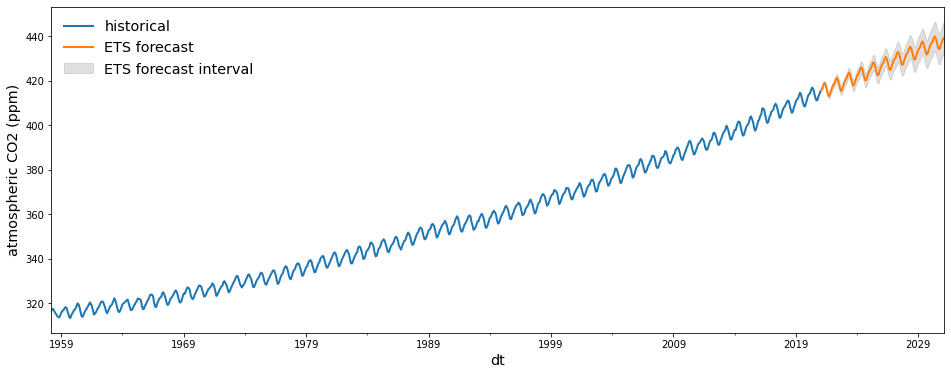

In [32]:
ax = tsf.viz.plot_time_series(
    [data["CO2"], forecast["mean"]],
    ["historical", "ETS forecast"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)
_ = ax.fill_between(forecast.index, forecast["pi_upper"], forecast["pi_lower"], color="gray", alpha=0.25, label="ETS forecast interval")
_ = ax.legend()

We can see that the prediction intervals get larger — there's more uncertainty — about forecast values farther out in time, but that the point forecast values look very similar to what we got with Holt-Winters.

### ARIMA models, and their extensions

Perhaps the most common, "classical" method for time series forecasting is ARIMA, which stands for AutoRegressive Integrated Moving Average. Such models describe the autocorrelations in time series data. For non-stationary data (like ours), one or more transformations must be applied to the values in order to properly model them. A simple but common method is...

#### differencing

This method is used to remove time-dependent patterns in the time series. It entails taking the difference between an observation and a lagged observation.

- first (non-seasonal) difference: $y_{t}^{\prime} = y_{t} - y_{t - 1}$, where lag = 1
- first seasonal difference: $y_{t}^{\prime} = y_{t} - y_{t - m}$, where lag is the seasonal component's period $m$
- second-order difference: $y_{t}^{\prime\prime} = y_{t}^{\prime} - y_{t - 1}^{\prime}$, i.e. taking the difference of the difference

A first non-seasonal difference is often enough to de-trend the data; similarly, a first seasonal difference can de-seasonalize. Depending on the time series, though, you may need to take one or multiple of these differences in order to produce a stationary series, and even combine it with another transformation to handle different time-dependent patterns (e.g. log-scaling to stabilize the variance). This process can be a bit subjective, but the unit root tests for stationarity described previously can help! Also, in the case of seasonal data, it's usually best to try seasonal differencing first.

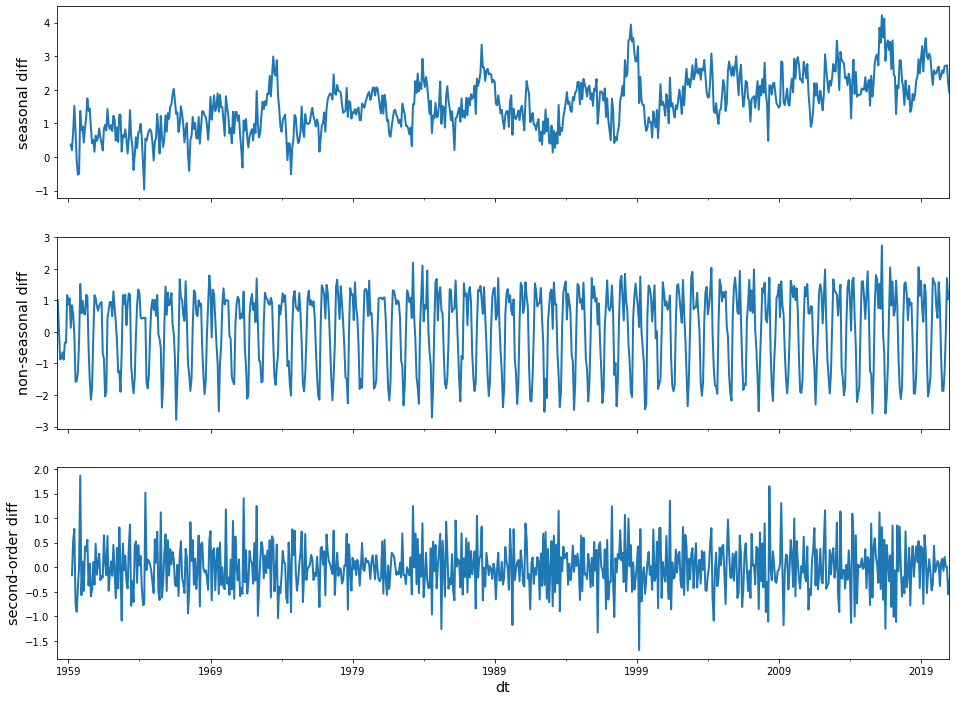

In [33]:
ax = tsf.viz.plot_time_series(
    [data["CO2"].diff(12), data["CO2"].diff(1), data["CO2"].diff(12).diff(1)],
    ["seasonal diff", "non-seasonal diff", "second-order diff"],
    subplots=True,
    figsize=(16, 12),
)

In [34]:
tsf.stats.kpss_test(data["CO2"].diff(periods=12).diff(periods=1).dropna())

/Users/burtondewilde/.pyenv/versions/3.9.1/envs/data-dives/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


stationarity               True
test statistic         0.044346
p-value                     0.1
num lags                     40
critical value 10%        0.347
critical value 5%         0.463
critical value 2.5%       0.574
critical value 1%         0.739
dtype: object

Confirmed: after second-order differencing, the time series is indeed stationary!

#### ARIMA(p,d,q)

An ARIMA(p,d,q) model can be used to forecast _non-seasonal_ time series data with meaningful patterns. It is a combination of three key components:

- **AR(p):** An autoregressive model of order $p$ models a target variable using a linear combination of its past values, up to a maximum lag of $p$: $y_{t} = \phi_{1} y_{t - 1} + ... + \phi_{p} y_{t - p} + \epsilon_{t} + c$.
- **MA(q):** A moving average model of order $q$ uses a weighted average of past forecast errors, up to a maximum lag of $q$: $y_{t} = \epsilon_{t} + \theta_{1} \epsilon_{t - 1} + ... + \theta_{q} \epsilon_{t - q} + c$. (Essentially, $q$ is the size of the sliding window over which averages are computed.) Note that this is not the same as the moving average _smoothing_ we did earlier!
- **I(d):** "Integration", the reverse of differencing, of order $d$, where $d$ is the _minimum_ number of (non-seasonal) first differences required to stationarize the data. Note that you can set $d = 0$ if the data is already stationary, which effectively reduces the model to ARMA(p,q).

Selecting suitable values for $p$, $d$, and $q$ can be a pain, but there are methods for inferring them from the data — either manually or automatically. For instance, we can use a measure like Akaike's (corrected) Information Criterion (AICc) to help select values for $p$ and $q$ by fitting models with a variety of parameters, then choosing the one that minimizes the information criterion value. Alternatively, we could use autocorrelation (and partial autocorrelation) plots to identify appropriate lag values: spikes in ACF at low lags indicate non-seasonal MA terms, while spikes in PACF at low lags indicate non-seasonal AR terms. (Note: This only really works if either $p$ or $q$ is 0.) And as we just saw, we can use KPSS tests on variously differenced data to select an appropriate value for $d$.

The other parameters (constant $c$, $\phi_{1 ... p}$,$\theta_{1 ... q}$) are estimated under the hood through maximum likelihood estimation (MLE).

Since this model doesn't work for seasonal data like ours, and the first seasonal differencing above didn't look particularly clean, let's instead fall back on an STL decomposition to create a _seasonally-adjusted_ version of our time series that we can model here.

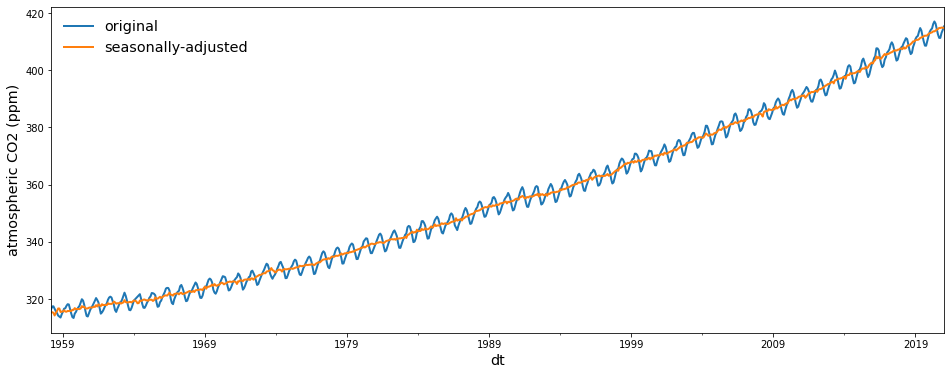

In [35]:
decomp = sm.tsa.STL(data[["CO2"]], seasonal=13, trend=21, robust=True).fit()
sa_data = data["CO2"] - decomp.seasonal

ax = tsf.viz.plot_time_series(
    [data["CO2"], sa_data],
    ["original", "seasonally-adjusted"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)

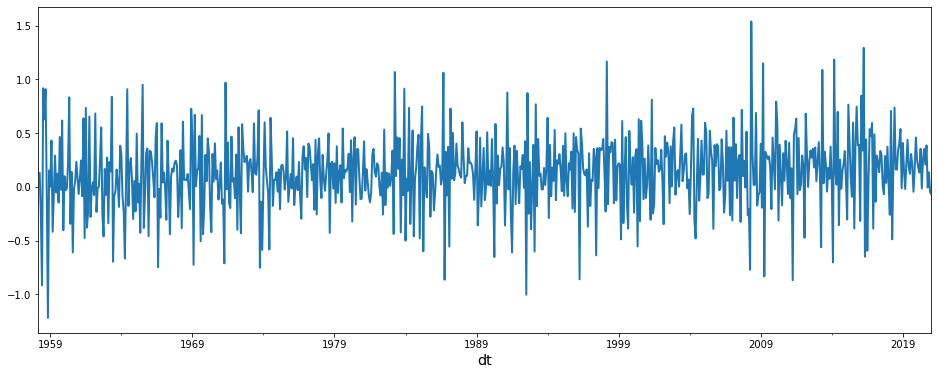

In [36]:
_ = sa_data.diff(1).plot.line()

In [37]:
tsf.stats.adfuller_test(sa_data.diff(1).dropna())

stationarity              True
test statistic       -6.322051
p-value                    0.0
num lags                    10
num obs                    743
critical value 1%    -3.439182
critical value 5%    -2.865438
critical value 10%   -2.568846
dtype: object

In [38]:
tsf.stats.kpss_test(sa_data.diff(1).dropna())

/Users/burtondewilde/.pyenv/versions/3.9.1/envs/data-dives/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


stationarity              False
test statistic         2.035515
p-value                    0.01
num lags                     23
critical value 10%        0.347
critical value 5%         0.463
critical value 2.5%       0.574
critical value 1%         0.739
dtype: object

Well, shoot. Our two tests for stationarity disagree — which can totally happen, since they're making different assumptions... — but now it's not clear if we should use $d = 1$ or $d = 2$.

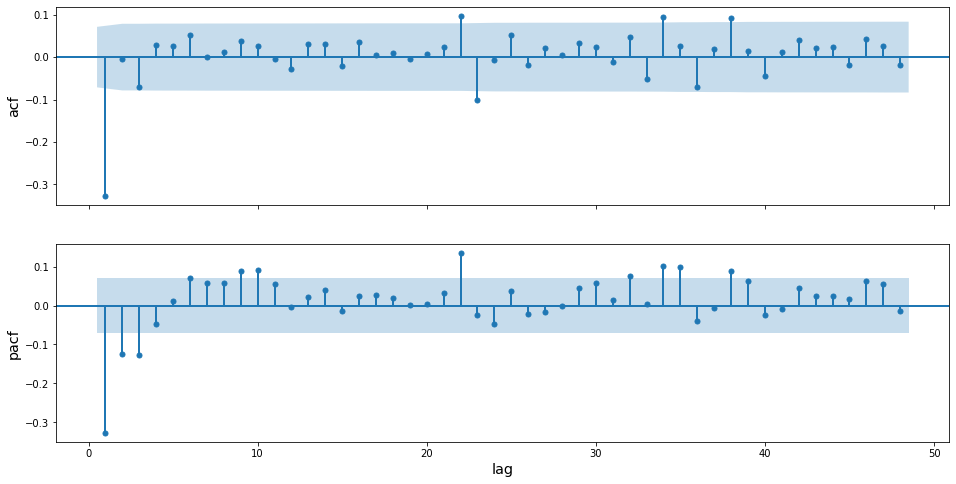

In [39]:
_ = tsf.viz.plot_autocorrelations(
    sa_data.diff(1).dropna(), lags=12 * 4, figsize=(16, 8)
)

Nuts! This is also an ambiguous result. Ideally, we'd have one plot with sinusoidal or exponential decaying values, and the other with a strong spike at lag $p$ (or $q$) with none beyond that. In this case, I guess we have both $p > 0$ and $q > 0$. So, wWe can just fit models for each combination, and choose the one with the lowest AIC...

In [40]:
# from statsmodels.tsa import ar_model

# result = ar_model.ar_select_order(data["CO2"].astype(float), 13, seasonal=True, period=12, trend="ct")
# result.ar_lags

In [41]:
result = (
    sm.tsa.arima.ARIMA(sa_data.astype(float), order=(1, 1, 2))
    .fit()
)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  755
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -202.726
Date:                Fri, 05 Feb 2021   AIC                            413.452
Time:                        12:40:02   BIC                            431.954
Sample:                    03-01-1958   HQIC                           420.580
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   4871.825      0.000       0.999       1.000
ma.L1         -1.4787      0.028    -52.126      0.000      -1.534      -1.423
ma.L2          0.4868      0.028     17.267      0.000       0.432       0.542
sigma2         0.0998      0.004     24.587      0.000       0.092       0.108
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                57.92
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.16
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
forecast = result.get_forecast(steps=120).summary_frame(alpha=0.05)
forecast.head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-02-01,415.196793,0.315866,414.577707,415.815879
2021-03-01,415.391468,0.356187,414.693354,416.089582
2021-04-01,415.586113,0.393453,414.814960,416.357266
2021-05-01,415.780729,0.428475,414.940933,416.620524
2021-06-01,415.975315,0.461779,415.070245,416.880384


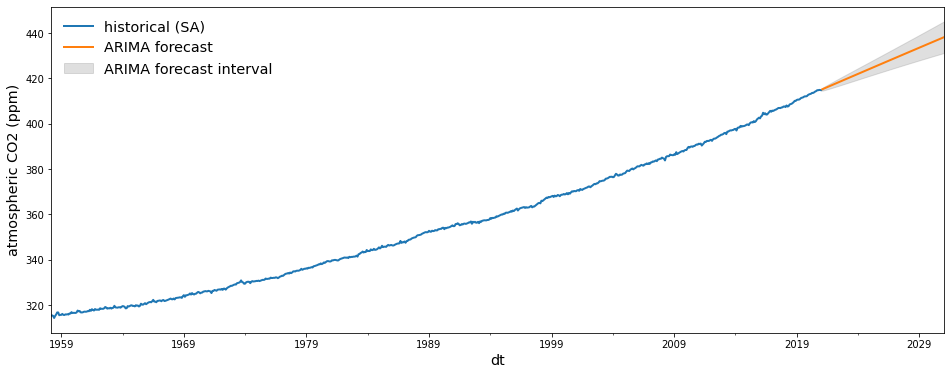

In [43]:
ax = tsf.viz.plot_time_series(
    [sa_data, forecast["mean"]],
    ["historical (SA)", "ARIMA forecast"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)
_ = ax.fill_between(forecast.index, forecast["mean_ci_upper"], forecast["mean_ci_lower"], color="gray", alpha=0.25, label="ARIMA forecast interval")
_ = ax.legend()

Not a bad forecast, tbh, if a bit unsatisfying without the seasonal pattern. Maybe we should use an ARIMA extension to model seasonality directly?

#### SARIMA(p,d,q)(P,D,Q,m)

A Seasonal ARIMA model adds additional but analogous terms to describe the seasonal component of a time series, where the big difference is that values and forecast errors are lagged by period $m$ instead of just 1. The result is a model with non-seasonal parameters (p, d, q) and corresponding seasonal parameters (P, D, Q), plus m. As before, we can guess appropriate values by looking at spikes the ACF/PACF plots, where the seasonal parmas are reflected in spikes at multiples of m.

At this level of complexity, it's nice to let an algorithm take charge in finding an optimal set of model parameters. Somewhat recently, the [`pmdarima` package](https://github.com/alkaline-ml/pmdarima) was released, and it includes an "auto-ARIMA" function for finding and fitting the best model. I highly recommend it! In the meantime, though, and for simplicity, let's just push on with our hands-on walkthrough:

In [44]:
result = (
    sm.tsa.arima.ARIMA(
        data["CO2"].astype(float),
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),
    )
    .fit()
)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                              CO2   No. Observations:                  755
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -267.843
Date:                          Fri, 05 Feb 2021   AIC                            543.686
Time:                                  12:40:05   BIC                            562.124
Sample:                              03-01-1958   HQIC                           550.794
                                   - 01-01-2021                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2800      0.068      4.147      0.000       0.148       0.412
ma.L1         -0.6685      0.051    -13.149      0.000      -0.768      -0.569
ma.S.L12      -0.8610      0.020    -42.187      0.000      -0.901      -0.821
sigma2         0.1179      0.006     21.281      0.000       0.107       0.129
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 6.51
Prob(Q):                              0.71   Prob(JB):                         0.04
Heteroskedasticity (H):               0.95   Skew:                            -0.02
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
forecast = result.get_forecast(steps=120).summary_frame(alpha=0.05)
forecast.head()

CO2,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-02-01,416.104179,0.343321,415.431283,416.777075
2021-03-01,416.922243,0.402426,416.133502,417.710984
2021-04-01,418.463673,0.437878,417.605448,419.321898
2021-05-01,419.217973,0.466933,418.302801,420.133145
2021-06-01,418.499728,0.493330,417.532819,419.466637


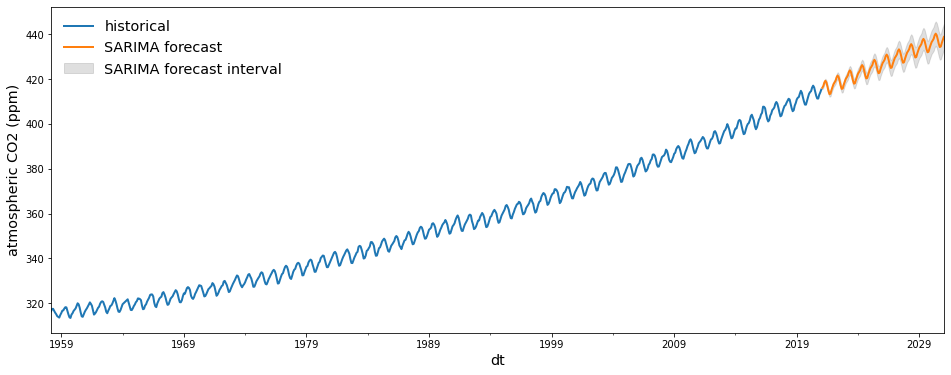

In [46]:
ax = tsf.viz.plot_time_series(
    [data["CO2"], forecast["mean"]],
    ["historical", "SARIMA forecast"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)
_ = ax.fill_between(forecast.index, forecast["mean_ci_upper"], forecast["mean_ci_lower"], color="gray", alpha=0.25, label="SARIMA forecast interval")
_ = ax.legend()

Looks good! There's more work to do in quantifying and validating "good" here — that's up next — but first, one final note:

Although there is some overlap, the ETS and ARIMA families of models are _distinct_, and one is not inherently better or more general than the other. If you're trying out multiple models and want to choose the "best" one, you'll have to do a proper evaluation and comparison of their performance.

### 5. model evaluation

So far, we've shown (but haven't discussed) summaries of our models' fits. For example:

In [47]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                              CO2   No. Observations:                  755
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -267.843
Date:                          Fri, 05 Feb 2021   AIC                            543.686
Time:                                  12:40:06   BIC                            562.124
Sample:                              03-01-1958   HQIC                           550.794
                                   - 01-01-2021                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2800      0.068      4.147      0.000       0.148       0.412
ma.L1         -0.6685      0.051    -13.149      0.000      -0.768      -0.569
ma.S.L12      -0.8610      0.020    -42.187      0.000      -0.901      -0.821
sigma2         0.1179      0.006     21.281      0.000       0.107       0.129
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 6.51
Prob(Q):                              0.71   Prob(JB):                         0.04
Heteroskedasticity (H):               0.95   Skew:                            -0.02
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

These summaries (generated by `statsmodels`) show key model metadata; coefficients' values, uncertainties, and statistical significances; and results from a variety of statistical tests to help assess the quality and validity of the model's fit. Some specific things to note:

- **Log Likelihood:** The logarithm of the value reached via maximum likelihood estimation (MLE), through which optimal model parameters were inferred from the observed data.
- **AIC/BIC/HQIC:** Various information criteria metrics (Akaike's, Bayesian, and Hannan-Quinn, respectively) that assess the quality of the model's fit. They're a nice complement to LL because they take model complexity into account. Smaller values => better fits.
- **coef, etc.:** The values, standard errors, standardized (i.e. `coef / std err`) values, p-values, and confidence intervals of the fit model's coefficients, one per row. `ar.L1` corresponds to the non-seasonal auto-regressive model's lag-1 coefficient; `ma.S.L12`, the seasonal moving-average model's lag-12 coefficient; and so on.

Before forging ahead with a model, we should always check these values. Also, we should do our due dilligence and perform some diagnostics on the residuals of the fitted model, where "residuals" here are the difference between the true historical values and the corresponding fitted values: $e_{t} = y_{t} − \hat{y}_{t}$. If we find any patterns in the residuals, the model has probably not taken advantage of all the available information, and thus could be improved.

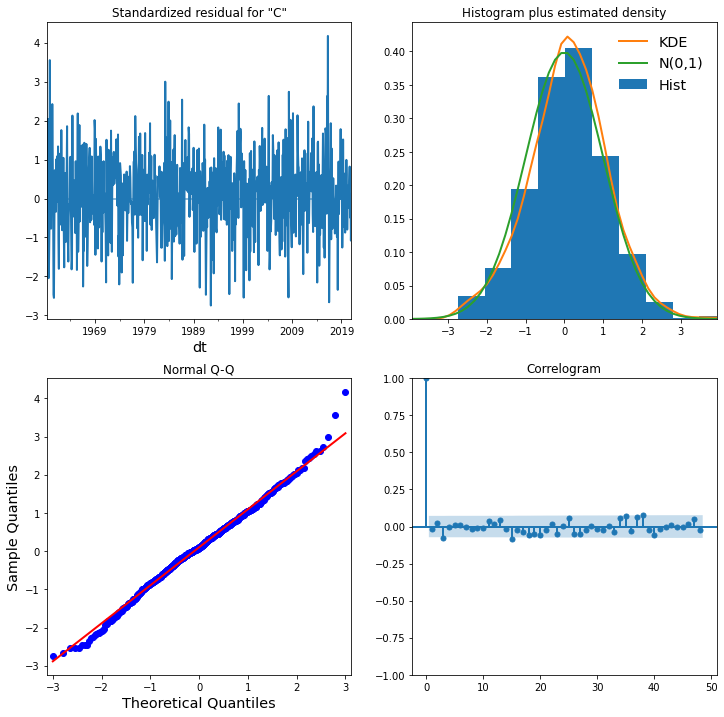

In [48]:
_ = result.plot_diagnostics(figsize=(12, 12), lags=12*4)

Here we see a few things: the model's residuals are indeed normally and independently distributed ("NID"), with a mean of 0 and constant variance, and there are no statistically significant autocorrelations. From this, we conclude that our forecasts and their intervals are fine.

### data splits

When training machine learning models, it's common to split available data into "training" and "test" sets, where the model's parameters are estimated based on observations in the training set and its performance is evaluated based on held-out observations in the test set. Commonly, test sets are comprised of ~20% of all observations, randomly selected, but time series datasets are special in that the _order_ of the observations is significant. So, a randomized test set won't work for time series forecasting.

Instead, we want a test set comprised of values later in time than the training set, covering a period about as long as the time horizon over which we intend to forecast. This setup imitates how we'll use the model's forecasts "in production", when we won't have the benefit of known observations against which to compare our predictions.

So, let's try the simplest case: We take the last 10 years of historical observations as our test set, and everything before that as the training set.

In [49]:
nobs_test = 12 * 10  # => 10 years of monthly observations

In [50]:
train_data = data.iloc[:-nobs_test, :]
test_data = data.iloc[-nobs_test:, :]
train_data.shape, test_data.shape

((635, 1), (120, 1))

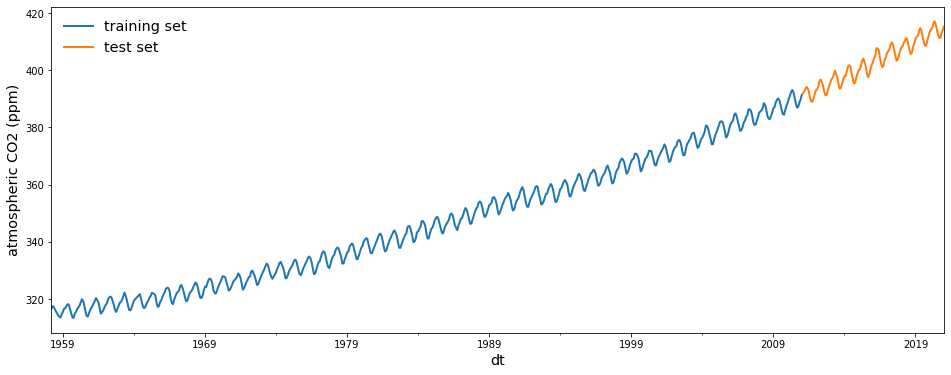

In [51]:
ax = tsf.viz.plot_time_series(
    [train_data["CO2"], test_data["CO2"]],
    ["training set", "test set"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)
_ = ax.legend()

Note the dates on the x-axis! This looks like our forecast plots — by design — though it's entirely historical data.

### performance metrics

Training a model on just the training dataset will look the same as before, but how do we evaluate on the test set? Typically, we'll use summaries of the model's _forecast errors_ — that is, the difference between observed and forecast values: $e_{T + h} = y_{T + h} - \hat{y}_{T + h}$. A variety of summarized errors are used, including:

- **mean absolute error (MAE):** $\text{mean}(\lvert e_{t} \rvert)$; depends on the data's scale, leads to forecasts of the median
- **root mean squared error (RMSE):** $\sqrt{\text{mean}(e_{t}^{2})}$; depends on the data's scale, leads to forecasts of the mean
- **mean absolute percentage error (MAPE):** $\text{mean}(\lvert (100 e_{t} / y_{t} \rvert)$; scale-independent, but assumes a meaningful zero value and blows up for $y_{t}$ close to zero

Now let's train a couple models, and compare their performance using these metrics. (We'll skip the other diagnostics mentioned above.)

In [52]:
# our baselines!
drift_forecast = tsf.naive.drift_forecast(train_data["CO2"], steps=nobs_test)
naive_seasonal_forecast = tsf.naive.naive_seasonal_forecast(train_data["CO2"], period=12, steps=nobs_test)

In [53]:
ets_result = (
    sm.tsa.ETSModel(
        train_data["CO2"].astype(float),
        trend="mul",
        seasonal="mul",
        error="add",
        seasonal_periods=12,
        initialization_method="estimated",
    )
    .fit()
)
ets_forecast = ets_result.forecast(steps=nobs_test)

In [54]:
sarima_result = (
    sm.tsa.arima.ARIMA(
        train_data["CO2"].astype(float),
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),
    )
    .fit()
)
sarima_forecast = sarima_result.forecast(steps=nobs_test)

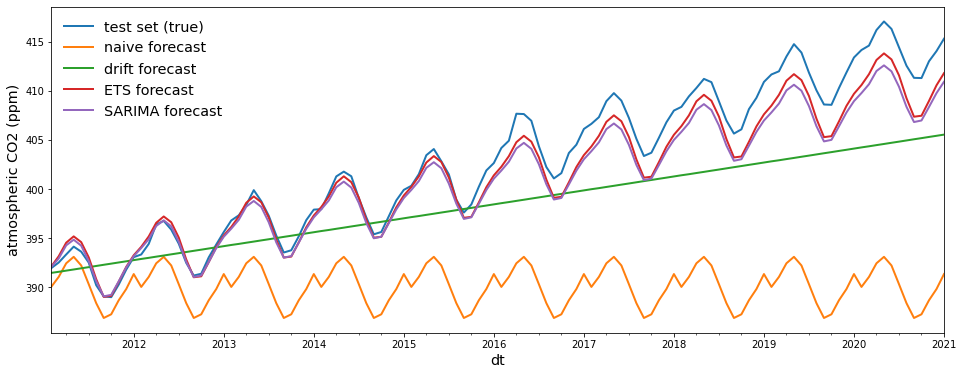

In [55]:
ax = tsf.viz.plot_time_series(
    [test_data["CO2"], naive_seasonal_forecast, drift_forecast, ets_forecast, sarima_forecast],
    ["test set (true)", "naive forecast", "drift forecast", "ETS forecast", "SARIMA forecast"],
    subplots=False,
    plot_kwargs={"ylabel": "atmospheric CO2 (ppm)"},
)
_ = ax.legend()

In [56]:
y_true = test_data["CO2"].astype(float)
cases = [
    ("naive", naive_seasonal_forecast),
    ("drift", drift_forecast),
    ("ETS", ets_forecast),
    ("SARIMA", sarima_forecast),
]

results = {}
for label, y_pred in cases:
    results[label] = {
        "MAE": sklearn.metrics.mean_absolute_error(y_true, y_pred),
        "RMSE": sklearn.metrics.mean_squared_error(y_true, y_pred, squared=False),
        "MAPE": sklearn.metrics.mean_absolute_percentage_error(y_true, y_pred),
    }

pd.DataFrame(results).T.sort_values(by="MAE", ascending=False)

,MAE,RMSE,MAPE
naive,12.721458,14.613866,0.031271
drift,4.763804,5.744997,0.011696
SARIMA,1.944125,2.431080,0.004765
ETS,1.556781,1.954971,0.003819


Unsurprisingly, the naive seasonal model performs the worst by far across all evaluation metrics, since it doesn't account for the data's strong upward trend. The ETS model with multiplicative components performs the best, just slightly better than the SARIMA model.

It's worth noting that there are more sophisticated ways to split the data, such as using a time series-specific version of cross-validation. There are also ways to evaluate the performance of forecasts with consideration for their forecast intervals, rather than just the point forecasts. But we've done enough here to cover the basics.